    LSTM 模型 : 新增預測 10 天後收盤價


### 載入套件

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import datetime, timedelta

### 取得台積電資料

In [10]:
# 取得日期
today = datetime(2025, 8, 29)
today = today - timedelta(days=10)
today = today.strftime("%Y-%m-%d")
today

'2025-08-19'

In [11]:
tsmc = yf.Ticker("2330.TW")

tsmc = tsmc.history(start="2018-01-01", end=today)

tsmc.reset_index(inplace=True)

tsmc.drop(columns=["Dividends", "Stock Splits"], inplace=True)

tsmc.columns=["mdate", "open_d", "high_d", "low_d", "close_d", "volume"]

tsmc["mdate"] = tsmc["mdate"].dt.strftime("%Y-%m-%d") # 整理日期格式
tsmc["open_d"] = tsmc["open_d"].map(lambda x : round(x, 2))
tsmc["high_d"] = tsmc["high_d"].map(lambda x : round(x, 2))
tsmc["low_d"] = tsmc["low_d"].map(lambda x : round(x, 2))
tsmc["close_d"] = tsmc["close_d"].map(lambda x : round(x, 2))
tsmc["volume"] = tsmc["volume"].map(lambda x : round(x/1000, 3))

tsmc

,mdate,open_d,high_d,low_d,close_d,volume
0,2018-01-02,190.10,190.92,189.69,190.92,18055.269
1,2018-01-03,193.79,195.43,193.38,194.61,29308.091
2,2018-01-04,197.08,197.08,194.20,196.66,29096.613
3,2018-01-05,197.08,197.08,195.43,197.08,22438.255
4,2018-01-08,198.72,199.13,197.49,198.72,20233.692
...,...,...,...,...,...,...
1846,2025-08-12,1180.00,1190.00,1170.00,1180.00,28917.167
1847,2025-08-13,1185.00,1200.00,1185.00,1200.00,37809.952
1848,2025-08-14,1185.00,1190.00,1175.00,1175.00,32991.791
1849,2025-08-15,1175.00,1185.00,1170.00,1180.00,22231.552


In [66]:
tsmc.loc[:, "mdate"].dtype, tsmc.loc[:, "open_d"].dtype, tsmc.loc[:, "high_d"].dtype, tsmc.loc[:, "low_d"].dtype, tsmc.loc[:, "close_d"].dtype, tsmc.loc[:, "volume"].dtype

(dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

### 將資料轉為浮點數

In [188]:
timeseries = tsmc[["close_d", "volume"]].values.astype('float32')

### 將資料標準化

In [189]:
# scaler = StandardScaler() # 標準化，平均值為 0，標準差為 1。
scaler = MinMaxScaler() # 正規化 0 ~ 1
timeseries = scaler.fit_transform(timeseries)

In [190]:
timeseries

array([[0.01358774, 0.10856541],
       [0.01719487, 0.17622805],
       [0.01919882, 0.17495644],
       ...,
       [0.9755615 , 0.19837794],
       [0.9804492 , 0.13367718],
       [0.9804492 , 0.10955529]], dtype=float32)

### 切分訓練資料和測試資料

In [191]:
train_size = int(len(timeseries) * 0.95)
train, val = timeseries[:train_size], timeseries[train_size:]

In [192]:
len(train), len(val)

(1758, 93)

In [193]:
train[0 : 0 + 5], train[0 + 5 :]

(array([[0.01358774, 0.10856541],
        [0.01719487, 0.17622805],
        [0.01919882, 0.17495644],
        [0.01960938, 0.13492008],
        [0.02121253, 0.12166415]], dtype=float32),
 array([[0.02121253, 0.11450532],
        [0.01679407, 0.14209332],
        [0.0155917 , 0.18307227],
        ...,
        [0.71275103, 0.3070489 ],
        [0.7458503 , 0.19360343],
        [0.74390507, 0.14941971]], dtype=float32))

### 設定 Dataset

In [194]:
def create_dataset(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback, :] # 特徵是五天資料的 "open_d", "high_d", "low_d","close_d", "volume"
        target = dataset[i+1:i+lookback+1][-1] # 標籤是最後一天資料的 "close_d", "volume"

        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y).view(-1, 2)

In [195]:
lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback)
X_val, y_val = create_dataset(val, lookback=lookback)
print(X_train.size(), y_train.size())
print(X_val.size(), y_val.size())

input_size = timeseries.shape[-1]

torch.Size([1753, 5, 2]) torch.Size([1753, 2])
torch.Size([88, 5, 2]) torch.Size([88, 2])


In [196]:
y_train

tensor([[0.0212, 0.1145],
        [0.0168, 0.1421],
        [0.0156, 0.1831],
        ...,
        [0.7128, 0.3070],
        [0.7459, 0.1936],
        [0.7439, 0.1494]])

### 設定 DataLoader

In [197]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=8, shuffle=False)

In [198]:
x1 = iter(loader)

In [199]:
first_X, first_y = next(x1)

In [200]:
first_y

tensor([[0.0212, 0.1145],
        [0.0168, 0.1421],
        [0.0156, 0.1831],
        [0.0172, 0.1294],
        [0.0196, 0.1652],
        [0.0200, 0.1304],
        [0.0212, 0.2288],
        [0.0264, 0.3000]])

### 設定 device

In [201]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [202]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

### 設定模型

In [203]:
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size=32, num_layers=2, batch_first = True)
        self.linear = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

### 實例化模型

In [204]:
model = LSTM_Model().to(device)

### 設定 cost function 及 optimizer

In [205]:
# optimizer = optim.Adam(model.parameters())
# 使用SDG或Adam演算法的lstm經常會用RMSprop做為優化方向，因為，它收斂的速度會比較快，原因是RMSprop 的學習速率(learning rate)會隨著之前的梯度總和作反向的調整。
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

### 訓練模型

In [206]:
n_epochs = 500

train_loss_array = []
val_loss_array = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 確認loss值的變化正常
    # if epoch % 100 ==0:
    #     print(y_pred)

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        # train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        train_loss = loss_fn(y_pred, y_train).item()

        y_pred = model(X_val)
        # test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        val_loss = loss_fn(y_pred, y_val).item()

        train_loss_array.append(train_loss)
        val_loss_array.append(val_loss)

    if epoch % 100 == 0:
        print("Epoch %d: train_loss %.4f, val_loss %.4f" % (epoch, train_loss, val_loss))

Epoch 0: train_loss 0.1706, val_loss 0.0072
Epoch 100: train_loss 0.0060, val_loss 0.0045
Epoch 200: train_loss 0.0047, val_loss 0.0037
Epoch 300: train_loss 0.0054, val_loss 0.0045
Epoch 400: train_loss 0.0042, val_loss 0.0047


### 測試模型

In [207]:
# with torch.no_grad():
with torch.torch.inference_mode():
    model.eval()
    # shift train predictions for plotting
    # 因為timeseries包含開、高、低、收等資料，因此需要timeseries[:, -2]取得最後一項 收盤價 的欄位長度即可
    train_plot = np.ones_like(timeseries[:, [-2, -1]]) * np.nan


    train_pred = model(X_train)

    # 取出 train_plot 資料放到 CPU 上並攤平成 "1維陣列"
    train_plot[lookback:train_size] = train_pred.cpu()

    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries[:, [-2, -1]]) * np.nan

    val_pred =  model(X_val)
    test_plot[train_size+lookback:len(timeseries)] = val_pred.cpu()

C:\Users\ANDY\AppData\Local\Temp\ipykernel_8784\1790645964.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = train_pred.cpu()
C:\Users\ANDY\AppData\Local\Temp\ipykernel_8784\1790645964.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = val_pred.cpu()


In [208]:
train_pred_close = train_plot[:, 0]   # 收盤價
train_pred_volume = train_plot[:, 1]  # 成交量
test_pred_close = test_plot[:, 0]   # 收盤價
test_pred_volume = test_plot[:, 1]  # 成交量

### 畫圖

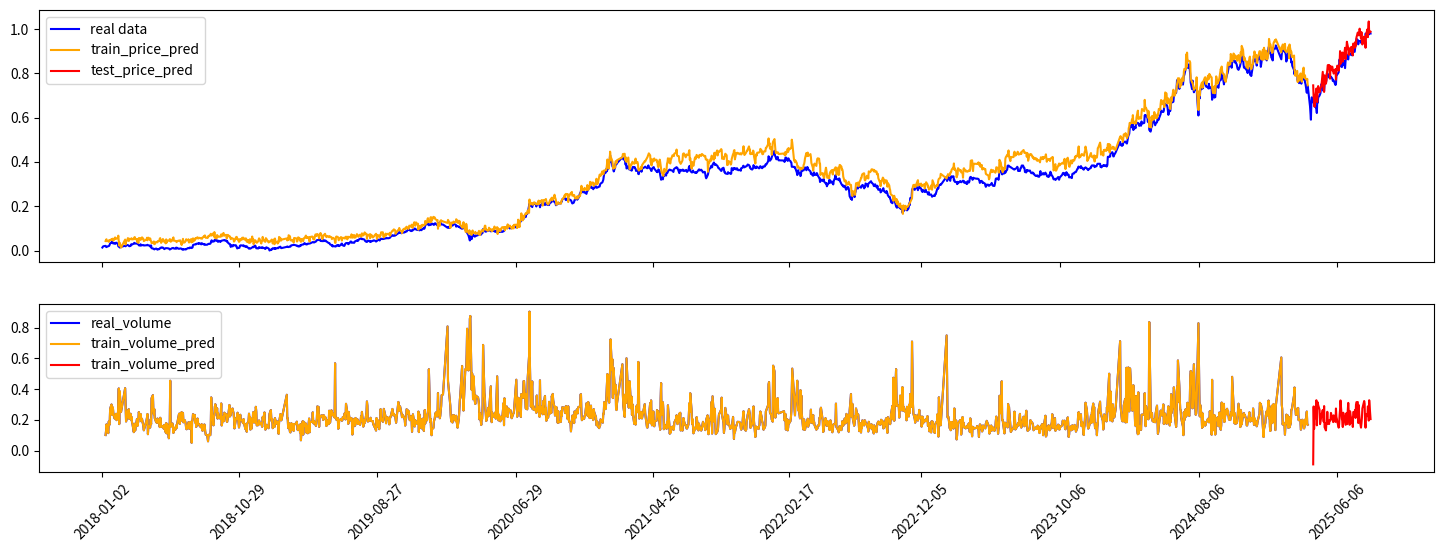

In [213]:
# plot
fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

dates = pd.to_datetime(tsmc["mdate"])

axes[0].plot(dates, timeseries[:, -2], label="real data", color="blue")
axes[0].plot(dates, train_pred_close, label="train_price_pred", color="orange")
axes[0].plot(dates, test_pred_close, label="test_price_pred", color="red")
axes[0].legend()  # 上方子圖的圖例

axes[1].plot(dates, train_pred_volume, label="real_volume", color="blue")
axes[1].plot(dates, train_pred_volume, label="train_volume_pred", color="orange")
axes[1].plot(dates, test_pred_volume, label="train_volume_pred", color="red")
axes[1].legend()  # 下方子圖的圖例

# 設定 x 軸標籤每隔 10 筆顯示一次
step = 200
plt.xticks(dates[::step], rotation=45)  # rotation=45 斜45度避免重疊

plt.show()

### 預測未來函式

In [238]:
def predict_future(model, recent_data, predict_days=10, lookback=5):
    model.eval()
    predictions_close = []
    predictions_volume = []

    current_input = recent_data[-lookback:].copy()  # 取最後 lookback 天資料當起始點

    for _ in range(predict_days):
        input_tensor = torch.tensor(current_input, dtype=torch.float32).unsqueeze(0).to(device)  # shape: [1, lookback, features]
        with torch.no_grad():
            pred = model(input_tensor).cpu().numpy()  # 預測出來是一個 scalar

            pred_close = pred[0][0]
            pred_volume = pred[0][1]

        # 新的一筆資料
        new_entry = current_input[-1].copy()
        new_entry[0] = pred_close
        new_entry[1] = pred_volume

        # 更新 current_input 滑動窗口
        current_input = np.vstack((current_input[1:], new_entry))
        predictions_close.append(pred_close)
        predictions_volume.append(pred_volume)

    return predictions_close, predictions_volume

### 執行預測

In [239]:
# recent_data 是完整 timeseries 的最後一段（例如 validation 結束後的資料）
recent_data = timeseries[-150:]  # 或者用 train+val 看你想從哪段開始預測

pred_close, pred_volume = predict_future(model, recent_data, predict_days=10, lookback=lookback)
print("未來 10 天預測收盤價 (正規化後):", pred_close)

未來 10 天預測收盤價 (正規化後): [np.float32(0.9797543), np.float32(0.9720471), np.float32(0.9611575), np.float32(0.9845229), np.float32(0.9661311), np.float32(0.962078), np.float32(0.97305626), np.float32(1.0003026), np.float32(0.9429047), np.float32(0.9452584)]


In [240]:
print("未來 10 天預測收盤價 (正規化後):", pred_close)

未來 10 天預測收盤價 (正規化後): [np.float32(0.9797543), np.float32(0.9720471), np.float32(0.9611575), np.float32(0.9845229), np.float32(0.9661311), np.float32(0.962078), np.float32(0.97305626), np.float32(1.0003026), np.float32(0.9429047), np.float32(0.9452584)]


In [241]:
print("未來 10 天預測成交量 (正規化後):", pred_volume)

未來 10 天預測成交量 (正規化後): [np.float32(0.19498979), np.float32(0.16997136), np.float32(0.20356312), np.float32(0.2840262), np.float32(0.2920672), np.float32(0.40319628), np.float32(0.42336512), np.float32(0.41035283), np.float32(0.24397801), np.float32(0.2283323)]


### 將預測值還原

In [246]:
# 只還原 close_d，其他欄位補上最後一筆即可
last_row = recent_data[-1].copy()
inv_preds = []

for pred in pred_close:
    row = last_row.copy()
    row[0] = pred  # 把預測的 close_d 塞進去
    inv = scaler.inverse_transform([row])[0]
    inv_preds.append(inv[0])  # 還原出來的 close_d

print("未來 10 天預測收盤價 (實際值):", inv_preds)

未來 10 天預測收盤價 (實際值): [np.float64(1179.2891056442727), np.float64(1171.4047549521422), np.float64(1160.2649221647994), np.float64(1184.167237427968), np.float64(1165.3528057495012), np.float64(1161.20654921798), np.float64(1172.4371118541303), np.float64(1200.3095287205913), np.float64(1141.5926826956193), np.float64(1144.000438253218)]


### 畫圖與實際資料比較

In [ ]:
import wget

wget.download("https://github.com/syh053/chinese_font_files/raw/refs/heads/main/ChineseFont.ttf")

'ChineseFont.ttf'

In [182]:
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont("ChineseFont.ttf")
mpl.rc("font", family="ChineseFont")

In [248]:
days_to_extend = 10

x = (tsmc["mdate"].to_numpy())[-110:]

# 取得今天日期
today = datetime.today().date()+timedelta(days=1)

# 轉換原始 list 最後一個日期為 date
last_date = datetime.strptime(x[-1], '%Y-%m-%d').date()

# 從 last_date 的下一天開始延續
current_date = last_date + timedelta(days=1)

new_dates = []

while len(new_dates) < 10:
    if current_date.weekday() < 5:  # 0~4 = Monday~Friday
        new_dates.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=1)

new_dates = np.array(new_dates)

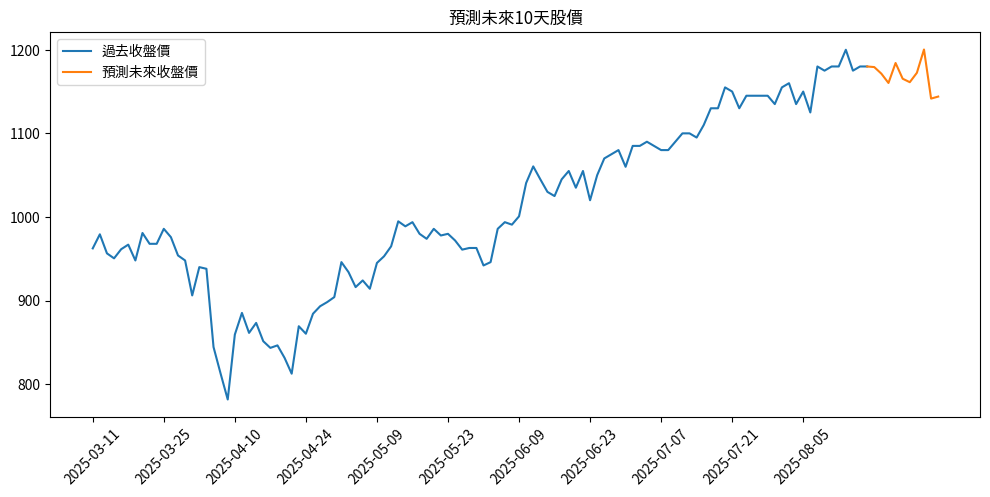

In [249]:
# 用於畫圖時與實際資料做銜接
real_close = scaler.inverse_transform(timeseries)[-110:, -2]  # 最近 30 天的真實收盤價

inv_preds = np.insert(inv_preds, 0, real_close[-1])
new_dates = np.insert(new_dates, 0, x[-1])

plt.figure(figsize=(12,5))
plt.plot(x, real_close, label="過去收盤價")
plt.plot(new_dates, inv_preds, label="預測未來收盤價")

plt.xticks(x[::10], rotation=45)

plt.legend()
plt.title("預測未來10天股價")
plt.show()

### 儲存模型

In [250]:
torch.save(obj=model.state_dict(), f="stock_pred.pth")